**4.1.2卷积运算的实现**

In [2]:
import torch  
from torch import nn
 
def corr2d(X, K): 
    # 二维卷积运算
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
           Y[i, j] = torch.sum ((X[i: i + h, j: j + w] * K))
    return Y

X = torch.tensor([[0.0, 1.0, 2.0, 3.0, 4.0], 
                  [1.0, 1.0, 2.0, 3.0, 3.0], 
                  [2.0, 2.0, 2.0, 3.0, 2.0],
                  [3.0, 3.0, 3.0, 3.0, 1.0],
                  [4.0, 3.0, 2.0, 1.0, 0.0]])

K = torch.tensor([[1.0, 1.0, 1.0], 
                  [2.0, 2.0, 2.0],
                  [3.0, 3.0, 3.0]])

print(corr2d(X, K))

tensor([[29., 39., 46.],
        [43., 47., 43.],
        [51., 43., 30.]])


**4.1.3边缘检测**

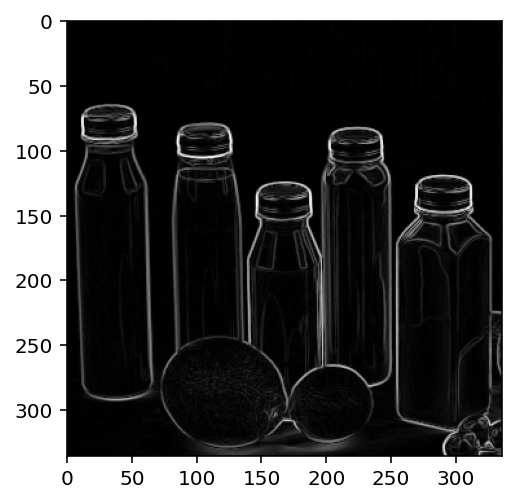

In [3]:
import torch
import cv2 
from  matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


img=cv2.imread("data/sobel_img.png",cv2.IMREAD_GRAYSCALE)
X= torch.tensor(img)
K = torch.tensor([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
Gx=corr2d(X,K)
K = torch.tensor([[1.0, 2.0, 1.0],[0.0, 0.0, 0.0],[-1.0, -2.0, -1.0]])
Gy=corr2d(X,K)
Y=torch.sqrt(Gx*Gx+Gy*Gy)-50.0  # 50.0为过滤的阈值

plt.imshow(Y, cmap='Greys_r')
plt.show()

**4.1.4卷积层代码实现**

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

**4.1.5填充**

In [5]:
import torch
from torch import nn

# 这里给出一个自定义卷积层，能够初始化卷积层，并对输入和输出进行维度转换
def comp_conv2d(conv2d, X):
    # (1, 1)代表batch_size和通道数都设置为1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)

    # 排除不感兴趣的前两个维度：batch_size大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，填充是在行和列的两侧进行的，所以填充为1时，输入特征图尺寸实际增加2
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

**4.1.6步幅**

In [6]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

**4.1.7池化**

In [7]:
X = torch.reshape(torch.arange(16, dtype=torch.float32), (1, 1, 4, 4))
print(X)
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
print(pool2d(X))
pool2d = nn.MaxPool2d((2, 3), padding=(1, 1), stride=(2, 3))
print(pool2d(X))

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
tensor([[[[ 5.,  7.],
          [13., 15.]]]])
tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])


In [8]:
X = torch.reshape(torch.arange(16, dtype=torch.float32), (1, 1, 4, 4))
X = torch.cat((X, X + 1), 1)
print(X)
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
print(pool2d(X))

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])


**4.2.1数据集的准备**

In [9]:
import torch
import torch.nn as nn
import torchvision
import sys
import time
import argparse
import sys
import torchvision

def load_data_fashion_mnist(batch_size, resize=None,root='./data/FashionMNIST'):
    # 首次运行将自动下载FashionMNIST数据集
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())

    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True,
        download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False,
        download=True, transform=transform)
    if sys.platform.startswith('win'):
        num_workers = 0  # 0表示不用额外的进程来加速读取数据
    else:
        num_workers = 4
    train_set = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
        shuffle=True, num_workers=num_workers)
    test_set = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
        shuffle=False, num_workers=num_workers)

    return train_set, test_set

**4.2.2流水线式训练流程**

首先使用argparse库来保存训练过程中所需使用的学习率、batchsize等自定义参数：

In [10]:
# resize_recommand = {"LeNet": None,
#                     "AlexNet": 224,
#                     "VGG": 224,
#                     "GoogLeNet": 96,
#                     "ResNet": 96}
def parse_args():
    parser = argparse.ArgumentParser(description="config")
    parser.add_argument('--dataset',default='data', type=str)
    parser.add_argument('--lr', default=0.1, type=float)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--num_epochs', default=100, type=int)
    parser.add_argument('--resize', default=None, type=int)
    parser.add_argument('--device', default='cpu', type=str)
    args = parser.parse_args(args=[])
    return args

config = parse_args()
print('config.resize = ', config.resize)

config.resize =  None


为了跟踪神经网络模型训练的效果，构造准确率评价函数：

In [11]:
def evaluate_accuracy(net, test_set, device=None):
    # 计算准确率
    if not device:
        device = next(iter(net.parameters())).device

    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in test_set:
            net.eval()  # 设为评估状态，dropout失效
            acc_sum += (net(X.to(device)).argmax(dim=1)== \
                        y.to(device)).float().sum().cpu().item()
            net.train()  # 改回训练模式
            n += y.shape[0]
    return acc_sum / n

构造训练函数

In [12]:
def train(net, train_set, test_set, num_epochs, lr, device):
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        start = time.time()
        train_l_sum, train_acc_sum, n, batch_count = 0, 0, 0, 0
        for i, (X, y) in enumerate(train_set):
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1

        train_loss = train_l_sum / batch_count
        train_acc = train_acc_sum / n
        test_acc = evaluate_accuracy(net, test_set)
        print("epoch:", epoch)
        print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, 
              ' f'test acc {test_acc:.3f}')
        print(f'time {time.time() - start} sec on {device}')

构造主函数，作为4.2.3~4.2.7节模板（本节中无需执行）

In [ ]:
config = parse_args()
# 可以根据需要对argparse内的参数进行更新
config.resize = None
config.device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

# 加载数据集
train_set, test_set = load_data_fashion_mnist(
    batch_size=config.batch_size,
    resize=config.resize, 
    root=config.dataset)

model = XXXNet()  # 替换为具体的网络

# 开始训练
train(model, train_set, test_set, config.num_epochs, config.lr, 
    config.device)


**4.2.3LeNet**

In [13]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        out = self.net(x)
        return out
config = parse_args()
config.resize = None
train_set, test_set = load_data_fashion_mnist(
    batch_size=config.batch_size,
    resize=config.resize, root=config.dataset)
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet()
train(model, train_set, test_set, config.num_epochs, config.lr, 
    config.device)


training on cuda
epoch: 0
loss 2.313, train acc 0.100, test acc 0.100
time 12.584901571273804 sec on cuda
epoch: 1
loss 2.306, train acc 0.102, test acc 0.100
time 10.182875394821167 sec on cuda
epoch: 2
loss 2.305, train acc 0.100, test acc 0.100
time 12.421482563018799 sec on cuda
epoch: 3
loss 2.304, train acc 0.101, test acc 0.100
time 9.237963914871216 sec on cuda
epoch: 4
loss 2.304, train acc 0.100, test acc 0.100
time 9.069371938705444 sec on cuda
epoch: 5
loss 2.303, train acc 0.102, test acc 0.101
time 11.322975158691406 sec on cuda
epoch: 6
loss 2.297, train acc 0.130, test acc 0.199
time 9.477518558502197 sec on cuda
epoch: 7
loss 1.687, train acc 0.371, test acc 0.524
time 10.548880577087402 sec on cuda
epoch: 8
loss 1.001, train acc 0.596, test acc 0.633
time 10.841414451599121 sec on cuda
epoch: 9
loss 0.824, train acc 0.677, test acc 0.692
time 10.679583549499512 sec on cuda
epoch: 10
loss 0.723, train acc 0.725, test acc 0.711
time 11.951382398605347 sec on cuda
epoch:

KeyboardInterrupt: 

**4.2.4AlexNet**

In [14]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(6400, 4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10))

    def forward(self, x):
        out = self.net(x)
        return out
    
config = parse_args()
config.resize = 224
train_set, test_set = load_data_fashion_mnist(batch_size=config.batch_size,
            resize=config.resize, root=config.dataset)
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AlexNet()
train(model, train_set, test_set, config.num_epochs, config.lr, config.device)


training on cuda
epoch: 0
loss 0.748, train acc 0.717, test acc 0.861
time 29.69559335708618 sec on cuda


KeyboardInterrupt: 

**4.2.5VGG**

In [15]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
        ratio = 4
        small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
        # 卷积部分
        conv_blks = []
        in_channels fgy= 1
        for (num_convs, out_channels) in small_conv_arch:
            conv_blks.append(
                self.vgg_block(num_convs, in_channels, out_channels))
            in_channels = out_channels

        self.net = nn.Sequential(
                        *conv_blks,
                        nn.Flatten(), # 全连接部分
                        nn.Linear(out_channels * 7 * 7, 4096),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
                        nn.Linear(4096, 10)
                        )

    def vgg_block(self, num_convs, in_channels, out_channels):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels,
                                    kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out
    
config = parse_args()
config.resize = 224
train_set, test_set = load_data_fashion_mnist(batch_size=config.batch_size,
            resize=config.resize, root=config.dataset)
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG()
train(model, train_set, test_set, config.num_epochs, config.lr, 
    config.device)

training on cuda
epoch: 0
loss 2.046, train acc 0.206, test acc 0.766
time 36.506420612335205 sec on cuda
epoch: 1
loss 0.398, train acc 0.856, test acc 0.888
time 36.73468899726868 sec on cuda


KeyboardInterrupt: 

**4.2.6GoogLeNet**

In [ ]:
class Inception(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super().__init__()

        #1x1卷积分支
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        #1x1卷积 -> 3x3卷积 分支
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        #1x1卷积 -> 5x5卷积 分支
        #使用2个3x3卷积替换1个5x5卷积以减小参数量
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        #3x3池化 -> 1x1卷积
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat(
            [self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogLeNet(nn.Module):

    def __init__(self, num_class=10):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):

        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

config = parse_args()
config.batch_size = 4
config.resize = 96
train_set, test_set = load_data_fashion_mnist(batch_size=config.batch_size,
            resize=config.resize, root=config.dataset)
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GoogLeNet()
train(model, train_set, test_set, config.num_epochs, config.lr,
    config.device)

training on cuda
epoch: 0
loss 0.601, train acc 0.784, test acc 0.886
time 1514.997925043106 sec on cuda
epoch: 1
loss 0.333, train acc 0.879, test acc 0.889
time 1494.6475493907928 sec on cuda
epoch: 2
loss 0.281, train acc 0.898, test acc 0.909
time 1493.8303489685059 sec on cuda
epoch: 3
loss 0.249, train acc 0.911, test acc 0.916
time 1512.3347475528717 sec on cuda
epoch: 4
loss 0.228, train acc 0.918, test acc 0.916
time 1488.1334714889526 sec on cuda


**4.2.7ResNet**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        b1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        def resnet_block(
            input_channels, num_channels, 
            num_residuals,first_block=False):
            blk = []
            for i in range(num_residuals):
                if i == 0 and not first_block:
                    blk.append(Residual(input_channels, num_channels,
                                        use_1x1conv=True, strides=2))
                else:
                    blk.append(Residual(num_channels, num_channels))
            return blk

        b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
        b3 = nn.Sequential(*resnet_block(64, 128, 2))
        b4 = nn.Sequential(*resnet_block(128, 256, 2))
        b5 = nn.Sequential(*resnet_block(256, 512, 2))
        net = nn.Sequential(b1, b2, b3, b4, b5,
                            nn.AdaptiveMaxPool2d((1, 1)),
                            nn.Flatten(), nn.Linear(512, 10))

        X = torch.rand(size=(1, 1, 224, 224))
        for layer in net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
        self.net = net

    def forward(self, x):
        out = self.net(x)
        return out

config = parse_args()
train_set, test_set = load_data_fashion_mnist(
    batch_size=config.batch_size,
    resize=config.resize, root=config.dataset)
config.device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet18()
train(model, train_set, test_set, config.num_epochs, config.lr, 
    config.device)
